In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:

        print(os.path.join(dirname, filename))
        break

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/rsna-bone-age/boneage-training-dataset.csv
/kaggle/input/rsna-bone-age/boneage-training-dataset/boneage-training-dataset/9273.png
/kaggle/input/rsna-bone-age/boneage-test-dataset/boneage-test-dataset/4518.png
/kaggle/input/w-net-pretrained/model_epoch_20.pth
/kaggle/input/w-net-pytorch-master/W-Net-Pytorch-master/train.py


In [1]:

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms
from PIL import Image
import os
from torch import Tensor
import numpy as np
from scipy.stats import norm
from scipy.ndimage import grey_opening
import tqdm
import torch.optim as optim
from sklearn.model_selection import train_test_split 


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
class Block(nn.Module):
    def __init__(self, in_filters, out_filters, seperable=True):
        super(Block, self).__init__()
        
        if seperable:
            
            self.spatial1=nn.Conv2d(in_filters, in_filters, kernel_size=3, groups=in_filters, padding=1)
            self.depth1=nn.Conv2d(in_filters, out_filters, kernel_size=1)
            
            self.conv1=lambda x: self.depth1(self.spatial1(x))
            
            self.spatial2=nn.Conv2d(out_filters, out_filters, kernel_size=3, padding=1, groups=out_filters)
            self.depth2=nn.Conv2d(out_filters, out_filters, kernel_size=1)
            
            self.conv2=lambda x: self.depth2(self.spatial2(x))
            
        else:
            
            self.conv1=nn.Conv2d(in_filters, out_filters, kernel_size=3, padding=1)
            self.conv2=nn.Conv2d(out_filters, out_filters, kernel_size=3, padding=1)
        
        self.batchnorm1=nn.BatchNorm2d(out_filters)
        self.batchnorm2=nn.BatchNorm2d(out_filters)

    def forward(self, x):
        
        x=self.batchnorm1(self.conv1(x)).clamp(0)
        
        x=self.batchnorm2(self.conv2(x)).clamp(0)
        
        return x

class UEnc(nn.Module):
    def __init__(self, squeeze, ch_mul=64, in_chans=3):
        super(UEnc, self).__init__()
        
        self.enc1=Block(in_chans, ch_mul, seperable=False)
        self.enc2=Block(ch_mul, 2*ch_mul)
        self.enc3=Block(2*ch_mul, 4*ch_mul)
        self.enc4=Block(4*ch_mul, 8*ch_mul)
        
        self.middle=Block(8*ch_mul, 16*ch_mul)
        
        self.up1=nn.ConvTranspose2d(16*ch_mul, 8*ch_mul, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.dec1=Block(16*ch_mul, 8*ch_mul)
        self.up2=nn.ConvTranspose2d(8*ch_mul, 4*ch_mul, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.dec2=Block(8*ch_mul, 4*ch_mul)
        self.up3=nn.ConvTranspose2d(4*ch_mul, 2*ch_mul, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.dec3=Block(4*ch_mul, 2*ch_mul)
        self.up4=nn.ConvTranspose2d(2*ch_mul, ch_mul, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.dec4=Block(2*ch_mul, ch_mul, seperable=False)
        
        self.final=nn.Conv2d(ch_mul, squeeze, kernel_size=(1, 1))
        
    def forward(self, x):
        
        enc1=self.enc1(x)
        
        enc2=self.enc2(F.max_pool2d(enc1, (2, 2)))
        
        enc3=self.enc3(F.max_pool2d(enc2, (2,2)))
        
        enc4=self.enc4(F.max_pool2d(enc3, (2,2)))
        
        
        middle=self.middle(F.max_pool2d(enc4, (2,2)))
        
        
        up1=torch.cat([enc4, self.up1(middle)], 1)
        dec1=self.dec1(up1)
        
        up2=torch.cat([enc3, self.up2(dec1)], 1)
        dec2=self.dec2(up2)
        
        up3=torch.cat([enc2, self.up3(dec2)], 1)
        dec3=self.dec3(up3)
        
        up4=torch.cat([enc1, self.up4(dec3)], 1)
        dec4=self.dec4(up4)
        
        
        final=self.final(dec4)
        
        return final
    def middle_forward(self,x):
        enc1=self.enc1(x)
        
        enc2=self.enc2(F.max_pool2d(enc1, (2, 2)))
        
        enc3=self.enc3(F.max_pool2d(enc2, (2,2)))
        
        enc4=self.enc4(F.max_pool2d(enc3, (2,2)))
        
        
        middle=self.middle(F.max_pool2d(enc4, (2,2)))
        
        return middle
        

class UDec(nn.Module):
    def __init__(self, squeeze, ch_mul=64, in_chans=3):
        super(UDec, self).__init__()
        
        self.enc1=Block(squeeze, ch_mul, seperable=False)
        self.enc2=Block(ch_mul, 2*ch_mul)
        self.enc3=Block(2*ch_mul, 4*ch_mul)
        self.enc4=Block(4*ch_mul, 8*ch_mul)
        
        self.middle=Block(8*ch_mul, 16*ch_mul)
        
        self.up1=nn.ConvTranspose2d(16*ch_mul, 8*ch_mul, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.dec1=Block(16*ch_mul, 8*ch_mul)
        self.up2=nn.ConvTranspose2d(8*ch_mul, 4*ch_mul, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.dec2=Block(8*ch_mul, 4*ch_mul)
        self.up3=nn.ConvTranspose2d(4*ch_mul, 2*ch_mul, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.dec3=Block(4*ch_mul, 2*ch_mul)
        self.up4=nn.ConvTranspose2d(2*ch_mul, ch_mul, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.dec4=Block(2*ch_mul, ch_mul, seperable=False)
        
        self.final=nn.Conv2d(ch_mul, in_chans, kernel_size=(1, 1))
        
    def forward(self, x):
        
        enc1 = self.enc1(x)
        
        enc2 = self.enc2(F.max_pool2d(enc1, (2, 2)))
        
        enc3 = self.enc3(F.max_pool2d(enc2, (2,2)))
        
        enc4 = self.enc4(F.max_pool2d(enc3, (2,2)))
        
        
        middle = self.middle(F.max_pool2d(enc4, (2,2)))
        
        
        up1 = torch.cat([enc4, self.up1(middle)], 1)
        dec1 = self.dec1(up1)
        
        up2 = torch.cat([enc3, self.up2(dec1)], 1)
        dec2 = self.dec2(up2)
        
        up3 = torch.cat([enc2, self.up3(dec2)], 1)
        dec3 =self.dec3(up3)
        
        up4 = torch.cat([enc1, self.up4(dec3)], 1)
        dec4 = self.dec4(up4)
        
        
        final=self.final(dec4)
        
        return final

class WNet(nn.Module):
    def __init__(self, squeeze, ch_mul=64, in_chans=3, out_chans=1000):
        super(WNet, self).__init__()
        if out_chans==1000:
            out_chans=in_chans
        self.UEnc=UEnc(squeeze, ch_mul, in_chans)
        self.UDec=UDec(squeeze, ch_mul, out_chans)
    def forward(self, x, returns='both'):
        
        enc = self.UEnc(x)
        
        if returns=='enc':
            return enc
        
        dec=self.UDec(F.softmax(enc, 1))
        
        if returns=='dec':
            return dec
        
        if returns=='both':
            return enc, dec
        
        else:
            raise ValueError('Invalid returns, returns must be in [enc dec both]')

In [3]:
# DataLoader implementation
class ImageDataset(torch.utils.data.Dataset):
    def __init__(self, image_dir, transform=None):
        self.image_dir = image_dir
        self.transform = transform
        self.image_paths = [os.path.join(image_dir, img) for img in os.listdir(image_dir) if img.endswith(('.png', '.jpg', '.jpeg'))][:1000]

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image

class SelfNormalize(object):
    def __call__(self, img):
        img_tensor = transforms.functional.to_tensor(img)
        mean = img_tensor.mean(dim=(1, 2), keepdim=True)
        std = img_tensor.std(dim=(1, 2), keepdim=True) + 1e-6
        img_tensor = (img_tensor - mean) / std
        return img_tensor

# Define the transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    SelfNormalize()
])

# Create the dataset
image_dir = "/kaggle/input/rsna-bone-age/boneage-training-dataset/boneage-training-dataset/"
dataset = ImageDataset(image_dir=image_dir, transform=transform)

# Create the DataLoader
train_loader = DataLoader(dataset, batch_size=8, shuffle=True)

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import transforms
from PIL import Image
import os
# DataLoader implementation
class ImageDataset(torch.utils.data.Dataset):
    def __init__(self, image_dir, transform=None):
        self.image_dir = image_dir
        self.transform = transform
        self.image_paths = [os.path.join(image_dir, img) for img in os.listdir(image_dir) if img.endswith(('.png', '.jpg', '.jpeg'))][1000:1300]

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image

class SelfNormalize(object):
    def __call__(self, img):
        img_tensor = transforms.functional.to_tensor(img)
        mean = img_tensor.mean(dim=(1, 2), keepdim=True)
        std = img_tensor.std(dim=(1, 2), keepdim=True) + 1e-6
        img_tensor = (img_tensor - mean) / std
        return img_tensor

# Define the transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    SelfNormalize()
])

# Create the dataset
image_dir = "/kaggle/input/rsna-bone-age/boneage-training-dataset/boneage-training-dataset/"
dataset = ImageDataset(image_dir=image_dir, transform=transform)

# Create the DataLoader
test_loader = DataLoader(dataset, batch_size=8, shuffle=True)



In [4]:
def gaussian_kernel(radius: int = 3, sigma: float = 4, device='cpu'):
    x_2 = np.linspace(-radius, radius, 2*radius+1) ** 2
    dist = np.sqrt(x_2.reshape(-1, 1) + x_2.reshape(1, -1)) / sigma
    kernel = norm.pdf(dist) / norm.pdf(0)
    kernel = torch.from_numpy(kernel.astype(np.float32))
    kernel = kernel.view((1, 1, kernel.shape[0], kernel.shape[1]))

    if device == 'cuda':
        kernel = kernel.cuda()

    return kernel


class NCutLoss2D(nn.Module):
    r"""Implementation of the continuous N-Cut loss, as in:
    'W-Net: A Deep Model for Fully Unsupervised Image Segmentation', by Xia, Kulis (2017)"""

    def __init__(self, radius: int = 4, sigma_1: float = 5, sigma_2: float = 1):
        r"""
        :param radius: Radius of the spatial interaction term
        :param sigma_1: Standard deviation of the spatial Gaussian interaction
        :param sigma_2: Standard deviation of the pixel value Gaussian interaction
        """
        super(NCutLoss2D, self).__init__()
        self.radius = radius
        self.sigma_1 = sigma_1  # Spatial standard deviation
        self.sigma_2 = sigma_2  # Pixel value standard deviation

    def forward(self, labels: Tensor, inputs: Tensor) -> Tensor:
        r"""Computes the continuous N-Cut loss, given a set of class probabilities (labels) and raw images (inputs).
        Small modifications have been made here for efficiency -- specifically, we compute the pixel-wise weights
        relative to the class-wide average, rather than for every individual pixel.

        :param labels: Predicted class probabilities
        :param inputs: Raw images
        :return: Continuous N-Cut loss
        """
        num_classes = labels.shape[1]
        kernel = gaussian_kernel(radius=self.radius, sigma=self.sigma_1, device=labels.device.type)
        loss = 0

        for k in range(num_classes):
            # Compute the average pixel value for this class, and the difference from each pixel
            class_probs = labels[:, k].unsqueeze(1)
            class_mean = torch.mean(inputs * class_probs, dim=(2, 3), keepdim=True) / \
                torch.add(torch.mean(class_probs, dim=(2, 3), keepdim=True), 1e-5)
            diff = (inputs - class_mean).pow(2).sum(dim=1).unsqueeze(1)

            # Weight the loss by the difference from the class average.
            weights = torch.exp(diff.pow(2).mul(-1 / self.sigma_2 ** 2))

            # Compute N-cut loss, using the computed weights matrix, and a Gaussian spatial filter
            numerator = torch.sum(class_probs * F.conv2d(class_probs * weights, kernel, padding=self.radius))
            denominator = torch.sum(class_probs * F.conv2d(weights, kernel, padding=self.radius))
            loss += nn.L1Loss()(numerator / torch.add(denominator, 1e-6), torch.zeros_like(numerator))

        return num_classes - loss


class OpeningLoss2D(nn.Module):
    r"""Computes the Mean Squared Error between computed class probabilities their grey opening.  Grey opening is a
    morphology operation, which performs an erosion followed by dilation.  Conceptually, this encourages the network
    to return sharper boundaries to objects in the class probabilities.

    NOTE:  Original loss term -- not derived from the paper for NCutLoss2D."""

    def __init__(self, radius: int = 2):
        r"""
        :param radius: Radius for the channel-wise grey opening operation
        """
        super(OpeningLoss2D, self).__init__()
        self.radius = radius

    def forward(self, labels: Tensor, *args) -> Tensor:
        r"""Computes the Opening loss -- i.e. the MSE due to performing a greyscale opening operation.

        :param labels: Predicted class probabilities
        :param args: Extra inputs, in case user also provides input/output image values.
        :return: Opening loss
        """
        smooth_labels = labels.clone().detach().cpu().numpy()
        for i in range(labels.shape[0]):
            for j in range(labels.shape[1]):
                smooth_labels[i, j] = grey_opening(smooth_labels[i, j], self.radius)

        smooth_labels = torch.from_numpy(smooth_labels.astype(np.float32))
        if labels.device.type == 'cuda':
            smooth_labels = smooth_labels.cuda()

        return nn.MSELoss()(labels, smooth_labels.detach())

In [5]:

# Assuming WNet and loss function are defined elsewhere

# Define the W-Net model
model = WNet(5)
psi = 0.5
loss=NCutLoss2D()
# Use DataParallel for multi-GPU support
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Training setup
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.001)

# Training loop
num_epochs = 20
epoch_rec_losses_train = []
epoch_ncut_losses_train = []
epoch_rec_losses_test = []
epoch_ncut_losses_test = []

print('Starting training...')
for epoch in tqdm.tqdm(range(num_epochs)):
    model.train()
    rec_losses_train = 0.0
    n_cut_losses_train = 0.0

    for images in train_loader:
        images = images.to(device)
        enc = model(images, returns='enc')
        n_cut_loss = loss(enc, images)
        n_cut_loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        dec = model(images, returns='dec')
        rec_loss = criterion(dec, images)
        rec_loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        rec_losses_train += rec_loss.item()
        n_cut_losses_train += n_cut_loss.item()

    epoch_rec_loss_train = rec_losses_train / len(train_loader.dataset)
    epoch_ncut_loss_train = n_cut_losses_train / len(train_loader.dataset)
    epoch_rec_losses_train.append(epoch_rec_loss_train)
    epoch_ncut_losses_train.append(epoch_ncut_loss_train)

    print(f"Epoch {epoch+1}/{num_epochs}, Train rec Loss: {epoch_rec_loss_train:.4f}")
    print(f"Epoch {epoch+1}/{num_epochs}, Train ncut Loss: {epoch_ncut_loss_train:.4f}")

    # Validation loop
    model.eval()
    rec_losses_test = 0.0
    n_cut_losses_test = 0.0

    with torch.no_grad():
        for images in test_loader:
            images = images.to(device)
            enc = model(images, returns='enc')
            n_cut_loss = loss(enc, images)
            dec = model(images, returns='dec')
            rec_loss = criterion(dec, images)
            rec_losses_test += rec_loss.item()
            n_cut_losses_test += n_cut_loss.item()

    epoch_rec_loss_test = rec_losses_test / len(test_loader.dataset)
    epoch_ncut_loss_test = n_cut_losses_test / len(test_loader.dataset)
    epoch_rec_losses_test.append(epoch_rec_loss_test)
    epoch_ncut_losses_test.append(epoch_ncut_loss_test)

    print(f"Epoch {epoch+1}/{num_epochs}, Test rec Loss: {epoch_rec_loss_test:.4f}")
    print(f"Epoch {epoch+1}/{num_epochs}, Test ncut Loss: {epoch_ncut_loss_test:.4f}")

    # Save the model every 10 epochs
    if (epoch + 1) % 10 == 0:
        model_path = f'/kaggle/working/model_epoch_{epoch+1}.pth'
        torch.save(model.state_dict(), model_path)
        print(f'Model saved at {model_path}')

print("Training complete.")


Starting training...


  0%|          | 0/20 [00:01<?, ?it/s]


KeyboardInterrupt: 

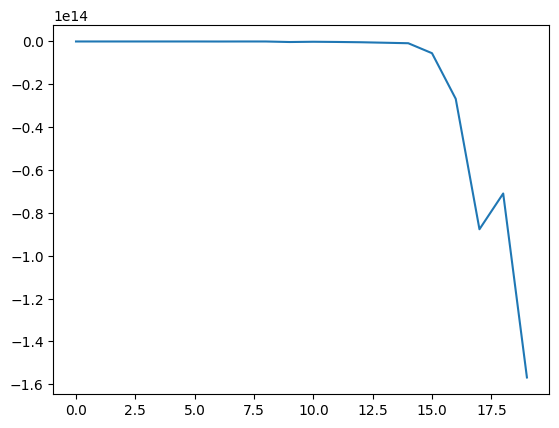

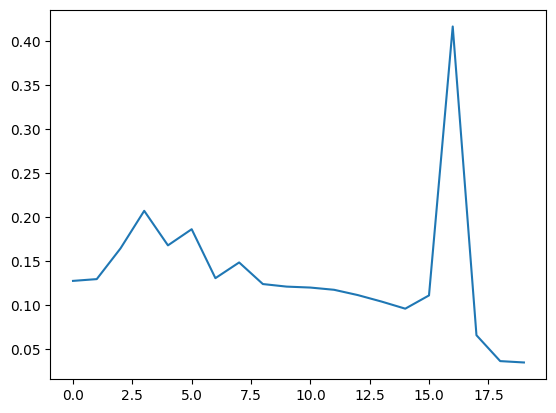

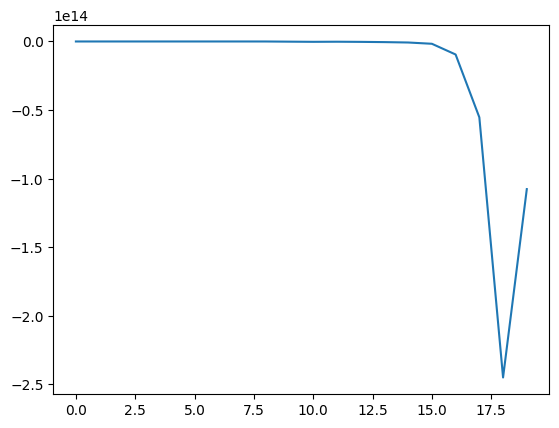

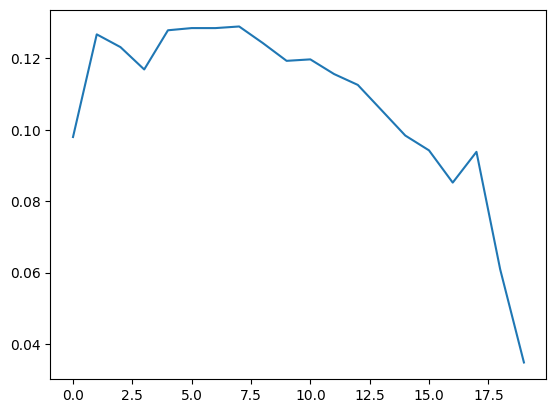

In [18]:
import matplotlib.pyplot as plt 
plt.plot(epoch_ncut_losses_test)
plt.show()
plt.plot(epoch_rec_losses_test)
plt.show()
plt.plot(epoch_ncut_losses_train)
plt.show()
plt.plot(epoch_rec_losses_train)
plt.show()

In [6]:
# Load the model file from the Kaggle dataset
model_path = '/kaggle/input/w-net-pretrained/model_epoch_20.pth'  # Update the path to your dataset

# Initialize the model
model = WNet(5)  # Update the values as needed
# Load the state dict
model.load_state_dict(torch.load(model_path))

# Move the model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

WNet(
  (UEnc): UEnc(
    (enc1): Block(
      (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (batchnorm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (batchnorm2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (enc2): Block(
      (spatial1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=64)
      (depth1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1))
      (spatial2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=128)
      (depth2): Conv2d(128, 128, kernel_size=(1, 1), stride=(1, 1))
      (batchnorm1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (batchnorm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (enc3): Block(
      (spatial1): 

In [7]:


class AgePredictor(nn.Module):
    def __init__(self, uenc, latent_dim, hidden_dims, output_dim):
        super(AgePredictor, self).__init__()
        self.uenc = uenc
        self.fc_layers = nn.ModuleList()
        
        # Update input_dim to include the gender feature
        input_dim = latent_dim + 1  # Adding 1 for the gender feature
        
        # Create fully connected layers
        prev_dim = input_dim
        for hidden_dim in hidden_dims:
            self.fc_layers.append(nn.Linear(prev_dim, hidden_dim))
            prev_dim = hidden_dim
        
        # Final layer to predict age
        self.fc_layers.append(nn.Linear(prev_dim, output_dim))
        
    def forward(self, x, gender):
        # Get the latent space from UEnc's forward_middle method
        latent = self.uenc.middle_forward(x)
        
        # Flatten the latent space
        latent = latent.view(latent.size(0), -1)
        
        # Concatenate the gender feature
        latent = torch.cat((latent, gender.unsqueeze(1)), dim=1)
        
        # Pass through fully connected layers
        for layer in self.fc_layers[:-1]:
            latent = F.relu(layer(latent))
        
        # Final output layer
        age = self.fc_layers[-1](latent)
        
        return age
# Assuming UEnc is already defined
uenc = model.UEnc
input_dim = 16 * 64 * (224 // 16) * (224 // 16)  # Adjust based on the actual input dimensions
hidden_dims = [512, 256, 128, 64, 32, 16]
output_dim = 1

age_predictor = AgePredictor(uenc, input_dim, hidden_dims, output_dim)


In [8]:
# Load the CSV file containing image paths and corresponding ages
import pandas as pd
bone_age_train_data = pd.read_csv("/kaggle/input/rsna-bone-age/boneage-training-dataset.csv")
bone_age_train_data['Image_Path'] = bone_age_train_data['id'].astype(str) + ".png"
def to_int(x):
    return int(x)
bone_age_train_data['male']=bone_age_train_data['male'].apply(to_int)

# Split the dataset into training and cross-validation sets
train_df, val_df = train_test_split(bone_age_train_data[:2000], test_size=0.3, random_state=42)

# DataLoader implementation
class ImageDataset(torch.utils.data.Dataset):
    def __init__(self, dataframe, image_dir, transform=None):
        self.dataframe = dataframe
        self.image_dir = image_dir
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        # Get the image path, age, and gender from the dataframe
        img_name = self.dataframe.iloc[idx]['Image_Path']
        age = self.dataframe.iloc[idx]['boneage']
        gender = self.dataframe.iloc[idx]['male']  # Assuming 'male' is the column name for gender (0 or 1)
        
        # Load and transform the image
        img_path = os.path.join(self.image_dir, img_name)
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        
        return image, age, gender

class SelfNormalize(object):
    def __call__(self, img):
        img_tensor = transforms.functional.to_tensor(img)
        mean = img_tensor.mean(dim=(1, 2), keepdim=True)
        std = img_tensor.std(dim=(1, 2), keepdim=True) + 1e-6
        img_tensor = (img_tensor - mean) / std
        return img_tensor

# Define the transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    SelfNormalize()
])

# Create the datasets
image_dir = "/kaggle/input/rsna-bone-age/boneage-training-dataset/boneage-training-dataset/"
train_dataset = ImageDataset(dataframe=train_df, image_dir=image_dir, transform=transform)
val_dataset = ImageDataset(dataframe=val_df, image_dir=image_dir, transform=transform)

# Create the DataLoaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
print('train is done')
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
print('val is done')


train is done
val is done


In [10]:
# Training parameters
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
age_predictor.to(device)
criterion = nn.MSELoss()  # Mean Squared Error loss
optimizer = optim.Adam(age_predictor.parameters(), lr=0.001)

# Lists to store the losses
train_losses = []
val_losses = []

# Training loop
num_epochs = 20
for epoch in tqdm.tqdm(range(num_epochs)):
    age_predictor.train()
    train_loss = 0.0
    print('here1')
    for images, ages, genders in train_loader:
        images, ages, genders = images.to(device), ages.to(device).float().unsqueeze(1), genders.to(device).float()
        
        optimizer.zero_grad()
        outputs = age_predictor(images, genders)
        loss = criterion(outputs, ages)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item() * images.size(0)
    
    train_loss /= len(train_loader.dataset)
    train_losses.append(train_loss)
    
    # Validation loop
    age_predictor.eval()
    val_loss = 0.0
    print('here2')
    with torch.no_grad():
        for images, ages, genders in val_loader:
            images, ages, genders = images.to(device), ages.to(device).float().unsqueeze(1), genders.to(device).float()
            
            outputs = age_predictor(images, genders)
            loss = criterion(outputs, ages)
            
            val_loss += loss.item() * images.size(0)
    
    val_loss /= len(val_loader.dataset)
    val_losses.append(val_loss)
    
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

print("Training complete.")
    

  0%|          | 0/20 [00:00<?, ?it/s]

here1
here2


  5%|▌         | 1/20 [01:59<37:49, 119.43s/it]

Epoch 1/20, Train Loss: 2906.2448, Val Loss: 6817.2250
here1
here2


 10%|█         | 2/20 [03:44<33:13, 110.75s/it]

Epoch 2/20, Train Loss: 2013.4350, Val Loss: 7434.8526
here1
here2


 15%|█▌        | 3/20 [05:28<30:32, 107.82s/it]

Epoch 3/20, Train Loss: 1761.9075, Val Loss: 6065.6778
here1
here2


 20%|██        | 4/20 [07:12<28:19, 106.23s/it]

Epoch 4/20, Train Loss: 1924.6246, Val Loss: 6034.2093
here1
here2


 25%|██▌       | 5/20 [08:57<26:26, 105.80s/it]

Epoch 5/20, Train Loss: 1757.2594, Val Loss: 5789.9045
here1
here2


 30%|███       | 6/20 [10:43<24:42, 105.92s/it]

Epoch 6/20, Train Loss: 1907.7892, Val Loss: 3054.4920
here1
here2


 35%|███▌      | 7/20 [12:27<22:48, 105.28s/it]

Epoch 7/20, Train Loss: 1829.7638, Val Loss: 3082.9004
here1
here2


 40%|████      | 8/20 [14:12<21:01, 105.12s/it]

Epoch 8/20, Train Loss: 1619.2766, Val Loss: 6014.9310
here1
here2


 45%|████▌     | 9/20 [15:56<19:15, 105.00s/it]

Epoch 9/20, Train Loss: 1604.7731, Val Loss: 5276.2737
here1
here2


 50%|█████     | 10/20 [17:42<17:32, 105.29s/it]

Epoch 10/20, Train Loss: 1657.6755, Val Loss: 2972.1449
here1
here2


 55%|█████▌    | 11/20 [19:28<15:47, 105.27s/it]

Epoch 11/20, Train Loss: 1706.2880, Val Loss: 6417.9175
here1
here2


 60%|██████    | 12/20 [21:13<14:01, 105.24s/it]

Epoch 12/20, Train Loss: 1585.1466, Val Loss: 5622.9761
here1
here2


 65%|██████▌   | 13/20 [22:57<12:15, 105.01s/it]

Epoch 13/20, Train Loss: 1613.1557, Val Loss: 6281.8944
here1
here2


 70%|███████   | 14/20 [24:42<10:30, 105.01s/it]

Epoch 14/20, Train Loss: 1663.8650, Val Loss: 7284.4828
here1
here2


 75%|███████▌  | 15/20 [26:27<08:44, 104.96s/it]

Epoch 15/20, Train Loss: 1553.4950, Val Loss: 4647.0636
here1
here2


 80%|████████  | 16/20 [28:12<06:59, 104.87s/it]

Epoch 16/20, Train Loss: 1572.7492, Val Loss: 2767.9606
here1
here2


 85%|████████▌ | 17/20 [29:56<05:14, 104.77s/it]

Epoch 17/20, Train Loss: 1585.4849, Val Loss: 3573.7155
here1
here2


 90%|█████████ | 18/20 [31:41<03:29, 104.90s/it]

Epoch 18/20, Train Loss: 1536.0289, Val Loss: 2391.8463
here1
here2


 95%|█████████▌| 19/20 [33:27<01:44, 104.96s/it]

Epoch 19/20, Train Loss: 1556.5361, Val Loss: 3938.3030
here1
here2


100%|██████████| 20/20 [35:11<00:00, 105.60s/it]

Epoch 20/20, Train Loss: 1479.2378, Val Loss: 2387.6463
Training complete.


In [12]:
test_df

,Case ID,Sex
0,4360,M
1,4361,M
2,4362,M
3,4363,M
4,4364,M
...,...,...
195,4555,F
196,4556,F
197,4557,F
198,4558,F


In [17]:
import pandas as pd
from PIL import Image
import os
import torch
from torch.utils.data import DataLoader
from torchvision import transforms
import torch.nn.functional as F
def change_gender(g):
    if g=='M':
        return 1
    else:
        return 0
# Load the test data
test_df = pd.read_csv("/kaggle/input/rsna-bone-age/boneage-test-dataset.csv")
test_df['Image_Path'] = test_df['Case ID'].astype(str) + ".png"
test_df['male'] = test_df['Sex'].apply(change_gender)

# Define the test dataset and dataloader
class TestImageDataset(torch.utils.data.Dataset):
    def __init__(self, dataframe, image_dir, transform=None):
        self.dataframe = dataframe
        self.image_dir = image_dir
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_name = self.dataframe.iloc[idx]['Image_Path']
        gender = self.dataframe.iloc[idx]['male']
        img_path = os.path.join(self.image_dir, img_name)
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, gender, img_name

# Define the transformations
class SelfNormalize(object):
    def __call__(self, img):
        img_tensor = transforms.functional.to_tensor(img)
        mean = img_tensor.mean(dim=(1, 2), keepdim=True)
        std = img_tensor.std(dim=(1, 2), keepdim=True) + 1e-6
        img_tensor = (img_tensor - mean) / std
        return img_tensor

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    SelfNormalize()
])

# Create the test dataset and dataloader
test_image_dir = "/kaggle/input/rsna-bone-age/boneage-test-dataset/boneage-test-dataset/"
test_dataset = TestImageDataset(dataframe=test_df, image_dir=test_image_dir, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Load the trained model (assuming you have already trained the model and saved the state_dict)
# age_predictor.load_state_dict(torch.load('path_to_saved_model.pth'))
age_predictor.eval()

# Move the model to the appropriate device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
age_predictor.to(device)

# Make predictions
predictions = []
with torch.no_grad():
    for images, genders, img_names in test_loader:
        images, genders = images.to(device), genders.to(device).float()
        outputs = age_predictor(images, genders)
        outputs = outputs.squeeze(1).cpu().numpy()
        for img_name, pred in zip(img_names, outputs):
            predictions.append((img_name, pred))

# Convert predictions to a DataFrame
pred_df = pd.DataFrame(predictions, columns=['Image_Path', 'Predicted_Age'])

# Save the DataFrame to a CSV file
#pred_df.to_csv('predictions.csv', index=False)


In [19]:
def id_gen(s):
    return s[:4]

In [20]:
id_gen('4360.png')

'4360'

In [22]:
pred_df['id']=pred_df['Image_Path'].apply(id_gen)
pred_df['pred']=pred_df['Predicted_Age']
pred_df=pred_df[['id','pred']]
pred_df.to_csv('pred.csv')

In [12]:
model_path = f'/kaggle/working/age_predictor_{epoch+1}.pth'
torch.save(age_predictor.state_dict(), model_path)

In [1]:
# Load the model file from the Kaggle dataset
model_path = '/kaggle/input/w-net-pretrained/model_epoch_20.pth'  # Update the path to your dataset

# Initialize the model
model = WNet(5)  # Update the values as needed
# Load the state dict
model.load_state_dict(torch.load(model_path))

# Move the model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

NameError: name 'age_predictor' is not defined

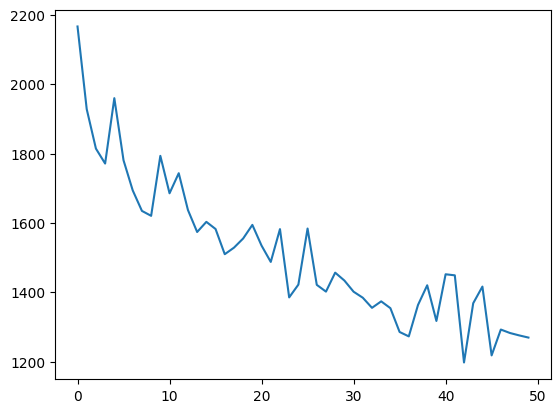

In [15]:
import matplotlib.pyplot as plt
plt.plot(train_losses)

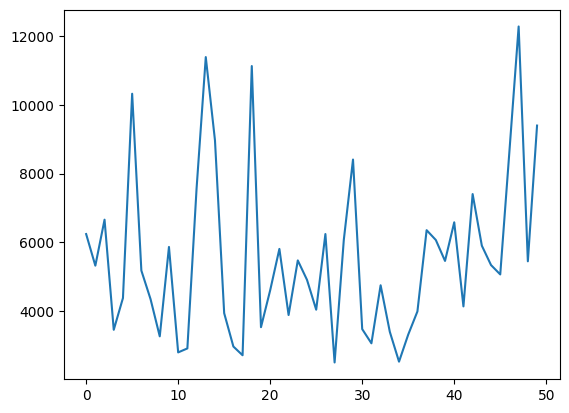

In [16]:
plt.plot(val_losses)

In [ ]:
# Load the model file from the Kaggle dataset
model_path = '/kaggle/input/w-net-pretrained/model_epoch_20.pth'  # Update the path to your dataset

# Assuming UEnc is already defined
uenc = model.UEnc
input_dim = 16 * 64 * (224 // 16) * (224 // 16)  # Adjust based on the actual input dimensions
hidden_dims = [512, 256, 128, 64, 32, 16]
output_dim = 1

age_predictor = AgePredictor(uenc, input_dim, hidden_dims, output_dim)
# Load the state dict
age_predictor.load_state_dict(torch.load(model_path))

# Move the model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
age_predictor.to(device)

In [51]:
res=[]
ages_l=[]
with torch.no_grad():
    for images, ages, genders in tval_loader:
        images, ages, genders = images.to(device), ages.to(device).float().unsqueeze(1), genders.to(device).float()
            
        outputs = age_predictor(images, genders)
        for i in outputs:
            res.append(i)
        for i in ages:
            ages_l.append(i)
            
        erors.append(eror)

In [48]:
print(torch.mean(erors))

TypeError: mean(): argument 'input' (position 1) must be Tensor, not list

In [4]:
bone_age_train_data = pd.read_csv("/kaggle/input/rsna-bone-age/boneage-training-dataset.csv")
bone_age_train_data

,id,boneage,male
0,1377,180,False
1,1378,12,False
2,1379,94,False
3,1380,120,True
4,1381,82,False
...,...,...,...
12606,15605,50,False
12607,15606,113,False
12608,15608,55,False
12609,15609,150,True


In [37]:
bone_age_train_data

,id,boneage,male,Image_Path
0,1377,180,0,1377.png
1,1378,12,0,1378.png
2,1379,94,0,1379.png
3,1380,120,1,1380.png
4,1381,82,0,1381.png
...,...,...,...,...
12606,15605,50,0,15605.png
12607,15606,113,0,15606.png
12608,15608,55,0,15608.png
12609,15609,150,1,15609.png


In [24]:
np.max(bone_age_train_data['boneage'])/12

19.0

In [25]:
bone_age_train_data['boneage']=bone_age_train_data['boneage']/12

(array([  91.,  406.,  831., 1127., 1824., 2344., 3126., 2182.,  571.,
         109.]),
 array([ 0.08333333,  1.975     ,  3.86666667,  5.75833333,  7.65      ,
         9.54166667, 11.43333333, 13.325     , 15.21666667, 17.10833333,
        19.        ]),
 <BarContainer object of 10 artists>)

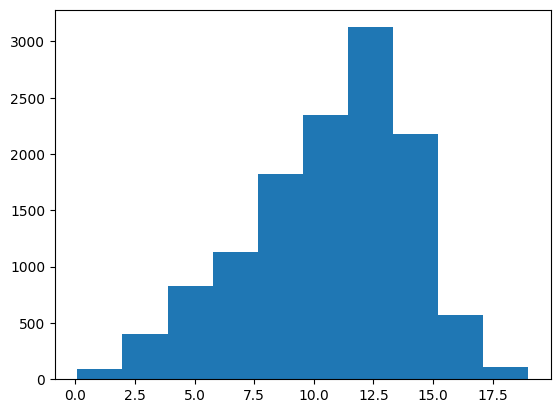

In [26]:
plt.hist(bone_age_train_data['boneage'])

In [9]:
bone_age_test_data = pd.read_csv("/kaggle/input/rsna-bone-age/boneage-test-dataset.csv")
bone_age_test_data

,Case ID,Sex
0,4360,M
1,4361,M
2,4362,M
3,4363,M
4,4364,M
...,...,...
195,4555,F
196,4556,F
197,4557,F
198,4558,F


In [4]:
train_path = "/kaggle/input/rsna-bone-age/boneage-training-dataset/boneage-training-dataset"
test_path = "/kaggle/input/rsna-bone-age/boneage-test-dataset/boneage-test-dataset"

train_folder = os.listdir(train_path)
test_folder = os.listdir(test_path)

print(len(train_folder))
print(len(test_folder))



12611
200


In [6]:
train_folder[:10]

['9273.png',
 '14127.png',
 '9292.png',
 '11396.png',
 '14260.png',
 '4353.png',
 '7968.png',
 '6490.png',
 '5511.png',
 '6262.png']

In [7]:
bone_age_train_data[bone_age_train_data['id']==9273]

,id,boneage,male
6946,9273,150,True


In [ ]:
counter=1
for i in 

In [12]:
bone_age_train_data.head()

,id,boneage,male,year
0,1377,180,False,15.000000
1,1378,12,False,1.000000
2,1379,94,False,7.833333
3,1380,120,True,10.000000
4,1381,82,False,6.833333


In [10]:
train_list_id = bone_age_train_data['id'].to_list()
test_list_id = bone_age_test_data['Case ID'].to_list()

In [11]:
test_folder[:10]

['4518.png',
 '4511.png',
 '4554.png',
 '4418.png',
 '4444.png',
 '4463.png',
 '4478.png',
 '4540.png',
 '4530.png',
 '4442.png']

In [12]:
bone_age_train_data['Image_Path'] = [f"{str(i)}.png" for i in train_list_id]
bone_age_test_data['Image Path'] = [f"{str(i)}.png" for i in test_list_id]

In [13]:
bone_age_train_data

,id,boneage,male,Image Path
0,1377,180,False,1377.png
1,1378,12,False,1378.png
2,1379,94,False,1379.png
3,1380,120,True,1380.png
4,1381,82,False,1381.png
...,...,...,...,...
12606,15605,50,False,15605.png
12607,15606,113,False,15606.png
12608,15608,55,False,15608.png
12609,15609,150,True,15609.png


In [32]:
def to_int(i):
    return int(i)

In [33]:
bone_age_train_data['boneage']=bone_age_train_data['boneage'].apply(to_int)

In [22]:
bone_age_test_data

,Case ID,Sex,Image Path
0,4360,M,4360.png
1,4361,M,4361.png
2,4362,M,4362.png
3,4363,M,4363.png
4,4364,M,4364.png
...,...,...,...
195,4555,F,4555.png
196,4556,F,4556.png
197,4557,F,4557.png
198,4558,F,4558.png


In [35]:
bone_age_test_data.columns = ['id','Sex','Image Path']

In [34]:
bone_age_train_data.columns = ['id','boneage', 'Sex', 'Image']

In [35]:
bone_age_train_data.head()

,id,boneage,Sex,Image
0,1377,15,False,1377.png
1,1378,1,False,1378.png
2,1379,7,False,1379.png
3,1380,10,True,1380.png
4,1381,6,False,1381.png


In [36]:
bone_age_test_data.head()

,Case ID,Sex,Image Path
0,4360,M,4360.png
1,4361,M,4361.png
2,4362,M,4362.png
3,4363,M,4363.png
4,4364,M,4364.png


In [37]:
bone_age_train_data['Sex'].value_counts()

Sex
True     6833
False    5778
Name: count, dtype: int64

In [38]:
bone_age_test_data['Sex'].value_counts()

Sex
M    100
F    100
Name: count, dtype: int64

In [39]:
# True - Male  or  M - 1        
# False - Female or F - 0

bone_age_train_data['Sex'] = bone_age_train_data['Sex'].replace({'False':0,'True':1})
bone_age_test_data['Sex'] = bone_age_test_data['Sex'].replace({'F':0,'M':1})

In [42]:
bone_age_train_data['Sex']=bone_age_train_data['Sex'].astype(int)

In [43]:
bone_age_train_data.head()

,id,boneage,Sex,Image Path
0,1377,180,0,1377.png
1,1378,12,0,1378.png
2,1379,94,0,1379.png
3,1380,120,1,1380.png
4,1381,82,0,1381.png


In [44]:
bone_age_test_data.head()

,id,Sex,Image Path
0,4360,1,4360.png
1,4361,1,4361.png
2,4362,1,4362.png
3,4363,1,4363.png
4,4364,1,4364.png


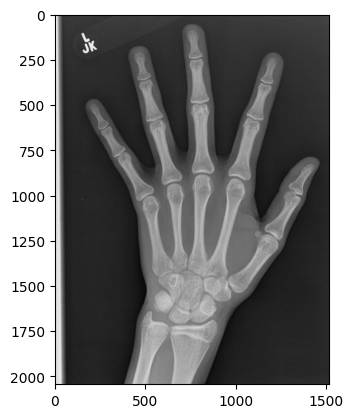

In [6]:
image=Image.open("/kaggle/input/rsna-bone-age/boneage-training-dataset/boneage-training-dataset/"+'1377.png')
#image = image.resize((224,224))
#image = image.convert("BW")
image = np.array(image)
plt.imshow(image,cmap='gray')

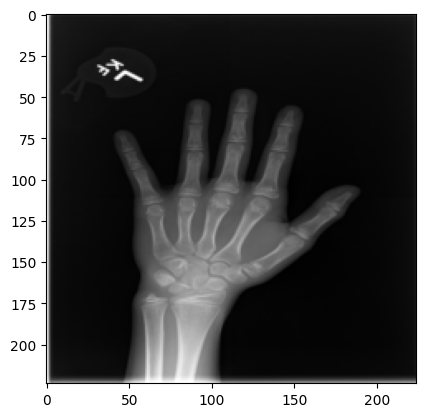

In [32]:
plt.imshow(images[0][2,:,:],cmap='gray')

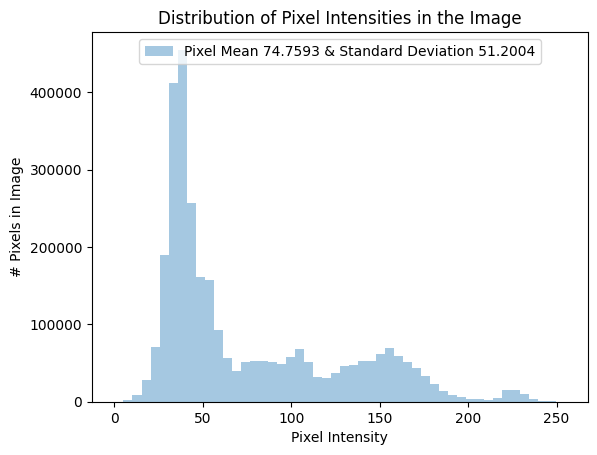

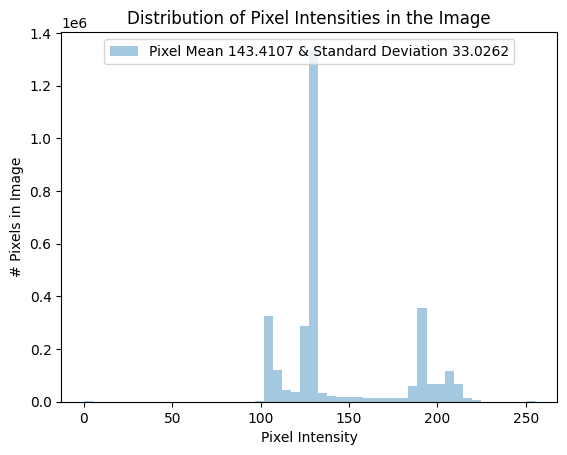

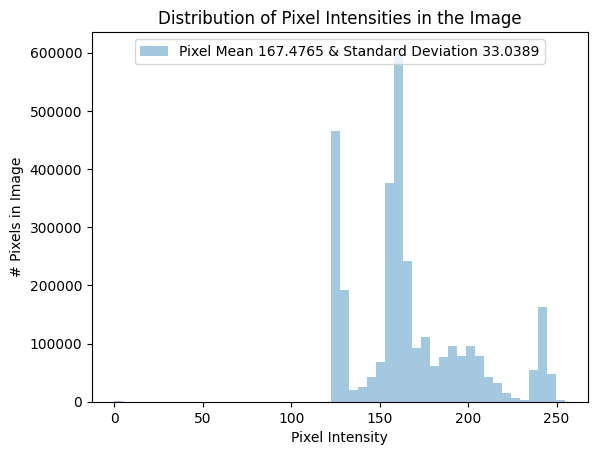

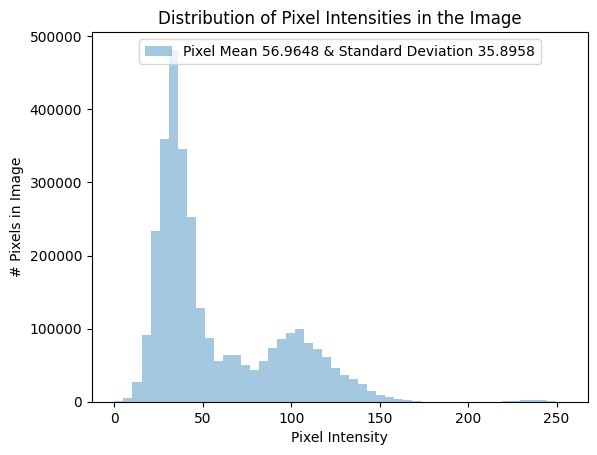

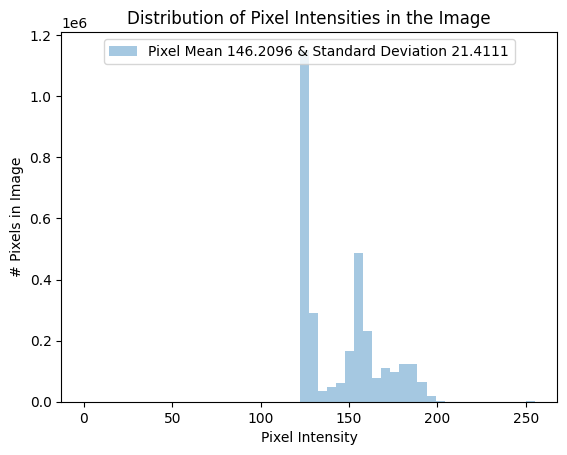

In [72]:
for img in bone_age_train_data['Image Path'][:5]:
    image = Image.open("/kaggle/input/rsna-bone-age/boneage-training-dataset/boneage-training-dataset/"+img)
    #(image = image.resize((224,224))
    #image = image.convert("RGB")
    image = np.array(image)
# Plot a histogram of the distribution of the pixels
    sns.distplot(image.flatten(), 
             label=f'Pixel Mean {np.mean(image.flatten()):.4f} & Standard Deviation {np.std(image.flatten()):.4f}', kde=False)
    plt.legend(loc='upper center')
    plt.title('Distribution of Pixel Intensities in the Image')
    plt.xlabel('Pixel Intensity')
    plt.ylabel('# Pixels in Image')
    plt.show()
    #train_data.append(image)

The dimensions of the image are 320 pixels width and 320 pixels height
The maximum pixel value is 3.4043 and the minimum is -1.4012
The mean value of the pixels is 0.0000 and the standard deviation is 1.0000


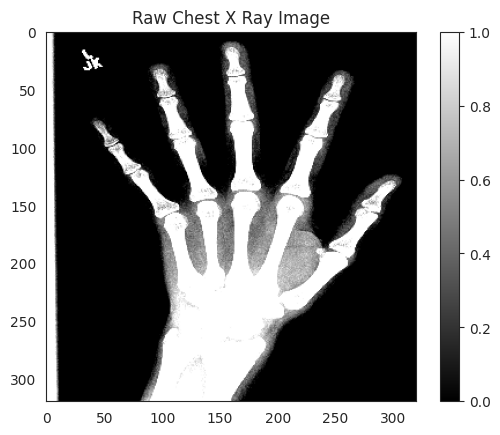

In [82]:
sns.set_style("white")
generated_image, label = generator.__getitem__(0)
plt.imshow(generated_image[0], cmap='gray')
plt.colorbar()
plt.title('Raw Chest X Ray Image')
print(f"The dimensions of the image are {generated_image.shape[1]} pixels width and {generated_image.shape[2]} pixels height")
print(f"The maximum pixel value is {generated_image.max():.4f} and the minimum is {generated_image.min():.4f}")
print(f"The mean value of the pixels is {generated_image.mean():.4f} and the standard deviation is {generated_image.std():.4f}")

In [105]:
generated_image[0][:,:,2]

array([[ 3.1112714 ,  3.18941   ,  3.0917368 , ..., -0.09240735,
        -0.03380346, -0.05333809],
       [ 3.130806  ,  3.287083  ,  3.1503406 , ..., -0.17054585,
        -0.05333809, -0.05333809],
       [ 3.2089446 ,  3.2675483 ,  3.0135982 , ..., -0.11194197,
        -0.1314766 , -0.01426884],
       ...,
       [ 2.9940636 ,  2.9940636 ,  2.974529  , ..., -0.61984223,
        -0.5221691 , -0.54170376],
       [ 2.8768559 ,  3.0526674 ,  2.9354599 , ..., -0.4440306 ,
        -0.60030764, -0.5026345 ],
       [ 2.9354599 ,  2.7987173 ,  2.7987173 , ..., -0.54170376,
        -0.5221691 , -0.5221691 ]], dtype=float32)

Text(0, 0.5, '# Pixel')

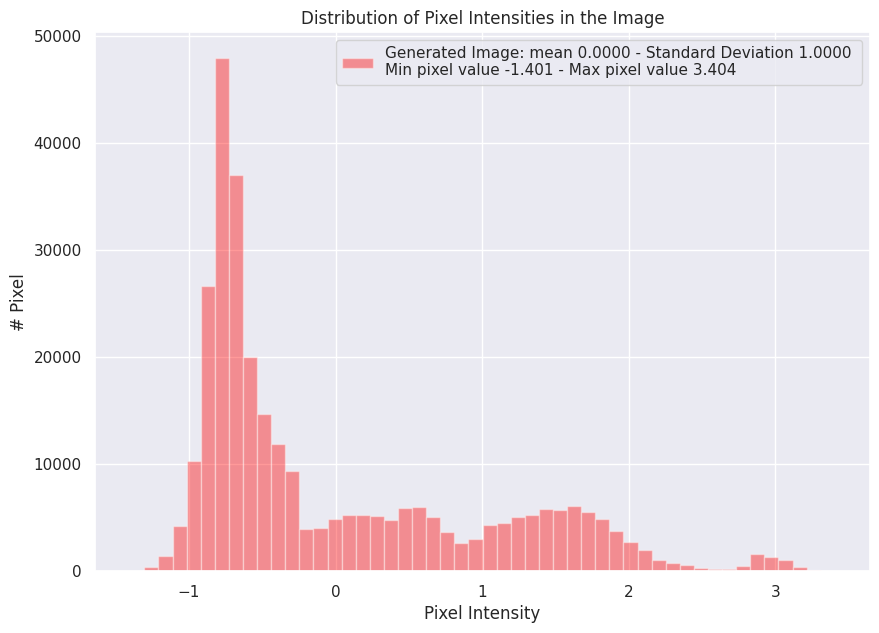

In [86]:
# Include a histogram of the distribution of the pixels
image=Image.open("/kaggle/input/rsna-bone-age/boneage-training-dataset/boneage-training-dataset/"+'1377.png')
#image = image.resize((224,224))
#image = image.convert("BW")
image = np.array(image)
sns.set()
plt.figure(figsize=(10, 7))

# Plot histogram for original iamge
#sns.distplot(image.flatten(), 
 #            label=f'Original Image: mean {np.mean(image.flatten())} - Standard Deviation {np.std(image.flatten())} \n '
  #           f'Min pixel value {np.min(image.flatten())} - Max pixel value {np.max(image.flatten())}',
    #         color='blue', 
     #        kde=False)

# Plot histogram for generated image
sns.distplot(generated_image[0].ravel(), 
             label=f'Generated Image: mean {np.mean(generated_image[0]):.4f} - Standard Deviation {np.std(generated_image[0]):.4f} \n'
             f'Min pixel value {np.min(generated_image[0]):.4} - Max pixel value {np.max(generated_image[0]):.4}', 
             color='red', 
             kde=False)

# Place legends
plt.legend()
plt.title('Distribution of Pixel Intensities in the Image')
plt.xlabel('Pixel Intensity')
plt.ylabel('# Pixel')

In [107]:
import tqdm

In [131]:
l=[]
bins=np.arange(-3,3,0.015)
for i in tqdm.tqdm(range(10000)):
    generated_image, label = generator.__getitem__(i)
    
    l.append(np.histogram(generated_image[0].ravel(), bins=bins)[0])

100%|██████████| 10000/10000 [08:23<00:00, 19.86it/s]


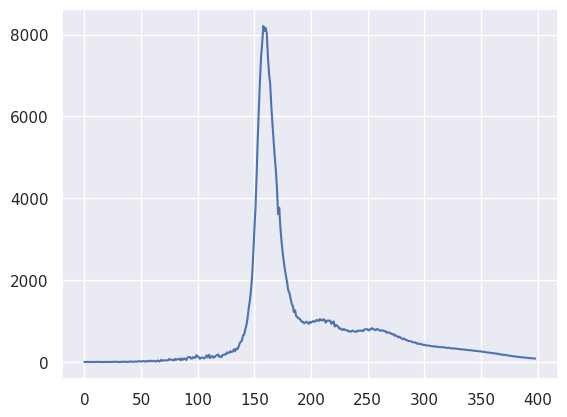

In [136]:
l=np.array(l)
plt.plot(np.mean(l,axis=0))

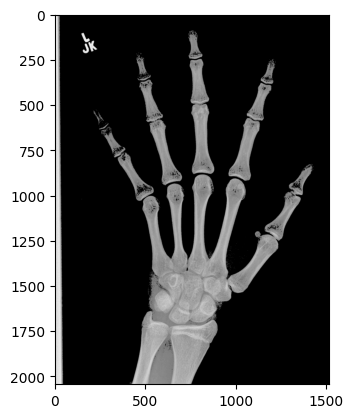

In [63]:
plt.imshow(new_im,cmap='gray')